Victor Mikhaylov, vmikhayl@ias.edu<br>Institute for Advanced Study, 2021-2022

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

cwd=os.getcwd()

import tfold.utils.utils as utils
import tfold.utils.seq_tools as seq_tools
seq_tools.load_mhcs()
seq_tools.load_tcrs()

from tfold.modeling import result_parse_tools

import importlib
if 0:
    importlib.reload(utils)

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  4.5 s
TCR loading from TCR.pckl. To update the pickle file, set use_pickle to False
loaded 2835 TCR sequences in  0.2 s


# make MHC MSA index

In [17]:
with open('./data/experimental_structures/processed_updated/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print(len(pmhcs))
#752->896

896


In [5]:
#get MHC unique pdbnums
pdbnums={'I_A':{},'II_A':{},'II_B':{}}
for x in pmhcs:
    if x['class']=='I': 
        mhc=seq_tools.load_NUMSEQ(x['M'])
        pdbnums['I_A'].setdefault('|'.join(mhc.data['pdbnum']),[]).append((mhc.info['locus'],mhc.info['allele'],mhc.seq()))
    else:
        mhc=seq_tools.load_NUMSEQ(x['M'])
        pdbnums['II_A'].setdefault('|'.join(mhc.data['pdbnum']),[]).append((mhc.info['locus'],mhc.info['allele'],mhc.seq()))
        mhc=seq_tools.load_NUMSEQ(x['N'])
        pdbnums['II_B'].setdefault('|'.join(mhc.data['pdbnum']),[]).append((mhc.info['locus'],mhc.info['allele'],mhc.seq()))
        
for k,v in pdbnums.items():
    print(k,len(v))
    for x in v.values():
        print(len(x))
        
#make a lookup table #cl_chain: pdbnum: (id, seq_example)
mhc_msa_index={}
for cl_chain,v in pdbnums.items():
    mhc_msa_index[cl_chain]={}
    for i,pdbnum in enumerate(v):
        seq=v[pdbnum][0][-1]
        mhc_msa_index[cl_chain][pdbnum]=(i,seq)
        
with open('./data/msas/mhc_msa_index.pckl','wb') as f:
    pickle.dump(mhc_msa_index,f)

I_A 5
745
19
1
2
1
II_A 7
18
70
19
11
7
2
1
II_B 4
6
103
14
5


In [6]:
#seq, name
inputs=[]
for cl_chain,v in mhc_msa_index.items():
    for i,seq in v.values():
        inputs.append([seq,'{:s}_{:d}'.format(cl_chain,i)])

In [7]:
inputs[0]

['GSHSMRYFYTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDQETRNVKAQSQTDRVDLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAAHAAEQQRAYLEGRCVEWLRRYLENGKETLQRT',
 'I_A_0']

# run alignments for MHC

In [18]:
with open('./data/msas/mhc_msa_index.pckl','rb') as f:
    mhc_msa_index=pickle.load(f)

In [21]:
#prepare jobs

output_dir=cwd+'/data/msas/MHC'

input_dir='/scratch/vmikhayl/tmp_mhc_msas'           
input_dir_server='/scratch/lustre/vmikhayl/tmp_mhc_msas'   #typhon
#input_dir_server=input_dir                                  #helios

inputs=[] #[seq,name] where name is class_chain_id
for cl_chain,v in mhc_msa_index.items():
    for i,seq in v.values():
        inputs.append([seq,'{:s}_{:d}'.format(cl_chain,i)])
print('inputs:',len(inputs))

n_tasks=200 #112#56       #our cluster: 64 nodes * 28 cores
max_run_time=60*5 #100    #in minutes
qos='short'               #medium 
exclusive=True            #to have enough memory for hhblist
local=False
slow_nodes=[]

sh_path='./make_mhc_msas.sh'
python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_MSA_tools.py'
argstring=f'msa {output_dir} --tmp_dir {input_dir_server}/fasta_tmp'

n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,exclusive=exclusive,
                        local=local,argstring=argstring)
print('n tasks:',n_tasks)

inputs: 16
n tasks: 16


# run alignments for TRV

In [31]:
#prepare jobs

output_dir=cwd+'/data/msas/TRV'

input_dir='/scratch/vmikhayl/tmp_trv_msas'           
#input_dir_server='/scratch/lustre/vmikhayl/tmp_mhc_msas'   #typhon
input_dir_server=input_dir                                  #helios

inputs=[[seq_tools.tcrs['9606','TRAV1-1','01'].seq(),'TRAV'],
        [seq_tools.tcrs['9606','TRBV10-1','01'].seq(),'TRBV']]

n_tasks=200 #112#56       #our cluster: 64 nodes * 28 cores
max_run_time=60*5 #100    #in minutes
qos='short'               #medium 
exclusive=True            #to have enough memory for hhblist
local=False              
slow_nodes=[]

sh_path='./make_trv_msas.sh'
python_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_MSA_tools.py'
argstring=f'msa {output_dir} --tmp_dir {input_dir}/fasta_tmp'

n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,exclusive=exclusive,
                        local=local,argstring=argstring)
print('n tasks:',n_tasks)

n tasks: 2


# make paired pMHC MSAs

## class I

In [32]:
import tfold.nn.nn_predict as nn_predict

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.6 s


In [43]:
#for reference, look at MHC MSA length
for filename in os.listdir('./data/msas/MHC/I_A_0'):
    if filename.endswith('a3m'):
        with open('./data/msas/MHC/I_A_0/'+filename) as f:
            s=f.read().split('\n')
        print(filename,len(s)//2)

uniref90_hits.a3m 9087
mgnify_hits.a3m 111
bfd_uniclust_hits.a3m 1308


peplen distribution:
8      11541
9     139966
10     38351
11      9018
12       372
13       397
14       232
15        25
Name: pep, dtype: int64
assays: 199902, mhcs: 161
               pep          mhc_a            kd
0       AAAAAAYAAM  (10090, D, b)   7333.347094
104835    RVYIYYNH  (10090, D, b)  50000.000000
105070   SAFEWHLTF  (10090, D, b)  11329.977020
105085   SAHVNGELV  (10090, D, b)     24.178188
105087   SAIANRLAL  (10090, D, b)      1.238977


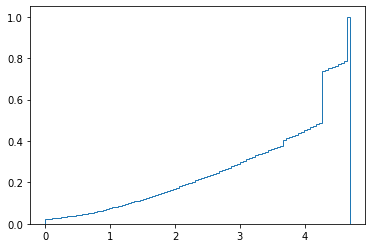

after reducing by true kd at threshold 100.0:
assays: 33365, mhcs: 141
making Kd predictions for 33365 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


seqnn run completed in 161.24462914466858
after reducing by predicted kd at threshold 100.0:
assays: 27763, mhcs: 137
after subsampling 100 assays per mhc:
assays: 8232, mhcs: 137


In [63]:
#read pmhc assays
train=pd.read_pickle('./data/pmhc_assays/train_i.pckl') 
print('peplen distribution:')
print(train['pep'].map(len).value_counts().sort_index()) #len distribution
train=train.sort_values('mhc_a')
print('assays: {}, mhcs: {}'.format(len(train),len(train['mhc_a'].unique())))
print(train.head(5))
plt.figure()
plt.hist(np.log10(train['kd'].values),bins=100,histtype='step',cumulative=1,density=True)
plt.show()
#note: in case AF relies on seq order when subsampling the MSA, sort entries by MHC; 
#(I believe, it uses the order only during training, not in inference)

#reduce to good binders
kd_threshold=100.
train=train[train['kd']<kd_threshold]
print('after reducing by true kd at threshold {}:'.format(kd_threshold))
print('assays: {}, mhcs: {}'.format(len(train),len(train['mhc_a'].unique())))
#predict kds
t0=time.time()
train=nn_predict.predict(train,'I',mhc_as_obj=False)
print('seqnn run completed in {}'.format(time.time()-t0))
#reduce to predicted good binders
train=train[train['seqnn_logkd']<np.log10(kd_threshold)]
print('after reducing by predicted kd at threshold {}:'.format(kd_threshold))
print('assays: {}, mhcs: {}'.format(len(train),len(train['mhc_a'].unique())))

#choose a subset
n_per_mhc=100
mhc_u=train['mhc_a'].unique()
train1=[]
for m in mhc_u:
    df=train[train['mhc_a']==m]
    train1.append(df.sample(min(n_per_mhc,len(df))))
train=pd.concat(train1)
print('after subsampling {} assays per mhc:'.format(n_per_mhc))
print('assays: {}, mhcs: {}'.format(len(train),len(train['mhc_a'].unique())))

In [87]:
#make master pdbnums for mhc and pep

###pep###
import tfold.nn.nn_utils as nn_utils
import tfold.modeling.template_tools as template_tools
pep_pdbnum=set()
pep_pdbnums_all=set()
for l in range(8,16):
    for tails in nn_utils.generate_registers_I(l):
        c_pdbnum=template_tools._make_pep_pdbnums_I(l,tails[0],tails[1])
        pep_pdbnums_all.add(tuple(c_pdbnum))
        pep_pdbnum|=set(c_pdbnum)
pep_pdbnums_all=[list(x) for x in pep_pdbnums_all]
pep_pdbnum=sorted(list(pep_pdbnum))
print('total pep pdbnums:',len(pep_pdbnums_all))
print(pep_pdbnum)

###mhc###
#NOTE: in MHC MSAs, used only pdbnums for mhcs in our structure database; here using all (for cl I)
#(in the future: make MHC MSAs for all pdbnums? will be a lot of them for cl II)

#collect all cl I mhc pdbnums
mhc_pdbnums_all=set()
for mhc in seq_tools.mhcs.values():
    if mhc.info['class']=='I':
        mhc_pdbnums_all.add(tuple(mhc.data['pdbnum']))
mhc_pdbnums_all=[list(x) for x in mhc_pdbnums_all]
print('different cl I pdbnums:',len(mhc_pdbnums_all))

#all res positions in them
pdbnum_entries=set()
for pdbnum in mhc_pdbnums_all:
    pdbnum_entries|=set(pdbnum)
pdbnum_entries=np.sort(list(pdbnum_entries))
print('res positions in cl I pdbnums:',len(pdbnum_entries))

#permute to ensure order
for pdbnum in mhc_pdbnums_all:
    pdbnum_entries[np.isin(pdbnum_entries,pdbnum)]=pdbnum
#check
for pdbnum in mhc_pdbnums_all:
    ind=np.isin(pdbnum_entries,pdbnum)
    if np.sum(ind)!=len(pdbnum):
        print('oops')
    if '|'.join(pdbnum_entries[ind])!='|'.join(pdbnum):
        print('oops')
mhc_pdbnum=np.array(pdbnum_entries)
print(mhc_pdbnum)

total pep pdbnums: 51
['   09', '   1 ', '   2 ', '   3 ', '   4 ', '   5 ', '   51', '   52', '   53', '   54', '   57', '   58', '   59', '   6 ', '   7 ', '   8 ', '   9 ', '  10 ', '  11 ', '  12 ', '  13 ', '  14 ', '  15 ', '  16 ']
different cl I pdbnums: 13
res positions in cl I pdbnums: 186
['   1 ' '   2 ' '   3 ' '   4 ' '   5 ' '   6 ' '   7 ' '   8 ' '   9 '
 '  10 ' '  11 ' '  12 ' '  13 ' '  14 ' '  15 ' '  16 ' '  17 ' '  18 '
 '  19 ' '  20 ' '  21 ' '  22 ' '  23 ' '  24 ' '  25 ' '  26 ' '  27 '
 '  28 ' '  29 ' '  30 ' '  31 ' '  32 ' '  33 ' '  34 ' '  35 ' '  36 '
 '  37 ' '  38 ' '  39 ' '  40 ' '  41 ' '  42 ' '  43 ' '  44 ' '  45 '
 '  46 ' '  47 ' '  48 ' '  49 ' '  50 ' '  51 ' '  52 ' '  53 ' '  54 '
 '  54A' '  54B' '  54C' '  55 ' '  56 ' '  57 ' '  58 ' '  59 ' '  60 '
 '  61 ' '  62 ' '  63 ' '  64 ' '  65 ' '  66 ' '  67 ' '  68 ' '  69 '
 '  70 ' '  71 ' '  72 ' '  73 ' '  74 ' '  75 ' '  76 ' '  77 ' '  78 '
 '  79 ' '  80 ' '  81 ' '  82 ' '  83 ' '

In [145]:
#convert peps and mhcs in assays to NUMSEQ, extend to master pdbnum
def pep_to_numseq(x):
    seq=x['pep']
    tails=x['seqnn_tails']
    return seq_tools.NUMSEQ(seq=seq,pdbnum=template_tools._make_pep_pdbnums_I(len(seq),tails[0],tails[1]))
def mhc_to_numseq(x):
    return seq_tools.mhcs[x['mhc_a']]
def extend_numseq(s,pdbnum):
    s_ext=seq_tools.NUMSEQ(seq='_'*len(pdbnum),pdbnum=pdbnum) #use '_' for gap symbol, to replace later
    ind1=np.isin(pdbnum,s.data['pdbnum'])
    ind2=np.isin(s.data['pdbnum'],pdbnum)
    s_ext.data[ind1]=s.data[ind2]
    return s_ext.data['seq']
pep_assays=train.apply(pep_to_numseq,axis=1)
pep_assays=np.stack(pep_assays.map(lambda x: extend_numseq(x,pep_pdbnum)).values)
mhc_assays=train.apply(mhc_to_numseq,axis=1)
mhc_assays=np.stack(mhc_assays.map(lambda x: extend_numseq(x,mhc_pdbnum)).values)
print(pep_assays.shape,mhc_assays.shape)

(8232, 24) (8232, 186)


In [146]:
#reduce to a3m, save pdbnum->filename index

pmhc_msa_index={'I_P':{},'I_M':{}} #cl_chain: pdbnum: id        

lower_vect=np.vectorize(lambda s:s.lower())
repl_gap_vect=np.vectorize(lambda s:s.replace('_','-'))
def reduce_matrix_to_pdbnum(matrix,ind):
    '''
    entries within pdbnum are kept, with gap symbols replaced by '-';
    entries outside pdbnum are made lowercase, with gap symbols dropped;
    outputs an array of strings
    '''
    matrix=matrix.copy()
    matrix[:,~ind]=lower_vect(matrix[:,~ind])
    matrix[:,ind]=repl_gap_vect(matrix[:,ind])
    return matrix

t0=time.time()
#pep
for i,pdbnum in enumerate(pep_pdbnums_all):
    ind=np.isin(pep_pdbnum,pdbnum) #which to keep
    pep_assays_reduced=reduce_matrix_to_pdbnum(pep_assays,ind)
    pep_a3m=[]
    for j,line in enumerate(pep_assays_reduced):
        pep_a3m.append(f'>{j}')
        pep_a3m.append(''.join(line).replace('_',''))        
    with open(f'./data/msas/pMHC/I_P_{i}.a3m','w') as f:
        f.write('\n'.join(pep_a3m))
    pmhc_msa_index['I_P']['|'.join(pdbnum)]=i
    
#mhc
for i,pdbnum in enumerate(mhc_pdbnums_all):
    ind=np.isin(mhc_pdbnum,pdbnum) #which to keep
    mhc_assays_reduced=reduce_matrix_to_pdbnum(mhc_assays,ind)
    mhc_a3m=[]
    for j,line in enumerate(mhc_assays_reduced):
        mhc_a3m.append(f'>{j}')
        mhc_a3m.append(''.join(line).replace('_',''))        
    with open(f'./data/msas/pMHC/I_M_{i}.a3m','w') as f:
        f.write('\n'.join(mhc_a3m))
    pmhc_msa_index['I_M']['|'.join(pdbnum)]=i

#save lookup table
with open('./data/msas/pmhc_msa_index.pckl','wb') as f:
    pickle.dump(pmhc_msa_index,f)
print('completed in {}'.format(time.time()-t0))

completed in 20.645625114440918


## class II

In [2]:
#read modeling results
result_dir=f'/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/processed'
print('loading...')
t0=time.time()
results_df=[]
for x in os.listdir(result_dir):
    results_df.append(pd.read_pickle(result_dir+f'/{x}/result.pckl'))
results_df=pd.concat(results_df)
print('completed in {}'.format(time.time()-t0))
print(len(results_df))
print(results_df.columns)

#reduce to best
print('reducing to best...')
t0=time.time()
results_df['lddt_score']=results_df['pep_lddt'].map(result_parse_tools.lddt_score)
reduced_df=result_parse_tools.reduce_to_best(results_df,['pmhc_id'],'lddt_score',how='min')
print(len(results_df))
print(len(reduced_df))
print('completed in {}'.format(time.time()-t0))

loading...
completed in 19.41299533843994
688216
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'class',
       'pep', 'mhc_a', 'mhc_b', 'kd', 'n_reg_filtered', 'af_n_reg',
       'seqnn_logkd'],
      dtype='object')
reducing to best...
688216
42413
completed in 90.40511631965637


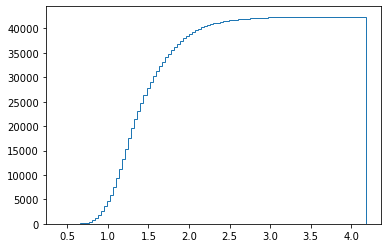

non-canonical tails dropped: 14
max lddt kept: 1.1537178652886946
DPB1      176
DQB1      153
DRB1     7938
DRB3      340
DRB4      403
DRB5      630
IAB       292
IEB        31
other      23
Name: locus, dtype: int64
3048


In [41]:
#score distrib
plt.figure()
plt.hist(reduced_df['lddt_score'],histtype='step',bins=100,cumulative=1)
plt.show()

#reduce to top N
N=10000
df_top=reduced_df.sort_values('lddt_score').head(N).copy()
df_top=df_top[df_top['register_identified']] #make sure register identified everywhere
n=len(df_top)
df_top=df_top[df_top['af_tails'].map(lambda x:(x[0]>=0)&(x[1]>=0))] #drop non-canonical tails
print('non-canonical tails dropped:',n-len(df_top))
print('max lddt kept:',df_top['lddt_score'].max())

#look at locus distrib
def map_locus(x):
    y=x.info
    if y['species'] in ['9606','10090']:
        return y['locus']
    else:
        return 'other'
df_top['locus']=df_top['mhc_b'].map(map_locus)
print(df_top['locus'].value_counts().sort_index())

#subsample DRB1
df_top=pd.concat([df_top[df_top['locus']=='DRB1'].sample(1000),df_top[df_top['locus']!='DRB1']])
print(len(df_top))

#sort my MHC_B
df_top['mhc_b_str']=df_top['mhc_b'].map(lambda x:'_'.join([x.info['species'],x.info['locus'],x.info['allele']]))
df_top=df_top.sort_values('mhc_b_str')

In [10]:
#len and tail distrib in discovery
target_df=pd.read_pickle('/scratch/vmikhayl/pmhc_modeling/discovery_dataset/run_10/target_df.pckl')
target_df=target_df[target_df['class']=='II']
print(len(target_df),target_df.columns)
print(target_df['pep'].map(len).value_counts().sort_index())
print(target_df['tails'].unique())

#conclusion: take len from 10 to 23 (covers most of hist) and all tails
#total pep registers:
#2+3+..+15=17*7=119 

62 Index(['class', 'cluster_seq', 'pdb_id', 'pmhc_id', 'date', 'tails',
       'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b', 'exclude_pdbs',
       'seqnn_logkds_all', 'seqnn_logkd', 'seqnn_tails', 'tails_prefiltered',
       'templates'],
      dtype='object')
10     1
11     2
12     5
13    15
14    11
15    12
16     6
18     1
19     2
20     3
21     1
22     2
23     1
Name: pep, dtype: int64
[(9, 3) (2, 2) (4, 2) (3, 1) (3, 10) (2, 5) (1, 3) (3, 3) (2, 3) (8, 3)
 (7, 3) (3, 4) (3, 2) (0, 3) (4, 10) (-1, 2) (2, 1) (1, 2) (1, 1) (6, 5)
 (4, 5) (4, 3) (2, 0) (5, 1) (2, 4) (5, 2)]


In [18]:
#make master pdbnums for mhc and pep

###pep###
import tfold.nn.nn_utils as nn_utils
import tfold.modeling.template_tools as template_tools

lmin,lmax=10,23 #choose min and max pep length; all >=0 tails will be considered

pep_pdbnum=set()
pep_pdbnums_all=set()
for l in range(lmin,lmax+1):
    for l_tail in range(l-8):
        c_pdbnum=template_tools._make_pep_pdbnums_II(l,l_tail)
        pep_pdbnums_all.add(tuple(c_pdbnum))
        pep_pdbnum|=set(c_pdbnum)
pep_pdbnums_all=[list(x) for x in pep_pdbnums_all]
pep_pdbnum0=sorted(list(pep_pdbnum))
pep_pdbnum=template_tools._make_pep_pdbnums_II(2*lmax-9,lmax-9) #this way it is sorted
print('total pep pdbnums:',len(pep_pdbnums_all))
print(pep_pdbnum)
print('pep pdbnums agree:',set(pep_pdbnum0)==set(pep_pdbnum))

###mhc###
#NOTE: in MHC MSAs, used only pdbnums for mhcs in our structure database; here using all

#collect all cl II mhc pdbnums
mhc_pdbnums_all={'A':set(),'B':set()} #by chain
for mhc in seq_tools.mhcs.values():
    if mhc.info['class']=='II':
        mhc_pdbnums_all[mhc.info['chain']].add(tuple(mhc.data['pdbnum']))
for k in mhc_pdbnums_all:
    mhc_pdbnums_all[k]=[list(x) for x in mhc_pdbnums_all[k]]
print('different cl II pdbnums:')
for k in mhc_pdbnums_all:
    print(k,len(mhc_pdbnums_all[k]))

#all res positions in them
pdbnum_entries={'A':set(),'B':set()}
for k in pdbnum_entries:
    for pdbnum in mhc_pdbnums_all[k]:
        pdbnum_entries[k]|=set(pdbnum)
    pdbnum_entries[k]=np.sort(list(pdbnum_entries[k]))
print('res positions in cl II pdbnums:')
for k in pdbnum_entries:
    print(k,len(pdbnum_entries[k]))

#permute to ensure order
for k in mhc_pdbnums_all:
    for pdbnum in mhc_pdbnums_all[k]:
        pdbnum_entries[k][np.isin(pdbnum_entries[k],pdbnum)]=pdbnum
#check
for pdbnum in mhc_pdbnums_all[k]:
    ind=np.isin(pdbnum_entries[k],pdbnum)
    if np.sum(ind)!=len(pdbnum):
        print('oops, missing')
    if '|'.join(pdbnum_entries[k][ind])!='|'.join(pdbnum):
        print('oops, order')
mhc_pdbnum={}
for k in pdbnum_entries: 
    mhc_pdbnum[k]=np.array(pdbnum_entries[k])
print(mhc_pdbnum)

total pep pdbnums: 119
['   0v', '   0w', '   0x', '   0y', '   0z', '   01', '   02', '   03', '   04', '   05', '   06', '   07', '   08', '   09', '   1 ', '   2 ', '   3 ', '   4 ', '   5 ', '   6 ', '   7 ', '   8 ', '   9 ', '  10 ', '  11 ', '  12 ', '  13 ', '  14 ', '  15 ', '  16 ', '  17 ', '  18 ', '  19 ', '  20 ', '  21 ', '  22 ', '  23 ']
pep pdbnums agree: True
different cl II pdbnums:
A 10
B 44
res positions in cl II pdbnums:
A 85
B 91
{'A': array(['   02', '   01', '   1 ', '   2 ', '   3 ', '   4 ', '   5 ',
       '   6 ', '   7 ', '   7A', '   8 ', '   9 ', '  10 ', '  11 ',
       '  12 ', '  13 ', '  14 ', '  19 ', '  20 ', '  21 ', '  22 ',
       '  23 ', '  24 ', '  25 ', '  26 ', '  27 ', '  28 ', '  29 ',
       '  30 ', '  31 ', '  32 ', '  33 ', '  34 ', '  35 ', '  36 ',
       '  37 ', '  38 ', '  39 ', '  42 ', '  43 ', '  44 ', '  45 ',
       '  46 ', '  47 ', '  48 ', '  49 ', '  50 ', '  51 ', '  52 ',
       '  53 ', '  54 ', '  59 ', '  60 ', '  

In [42]:
#convert peps and mhcs in assays to NUMSEQ, extend to master pdbnum
def pep_to_numseq(x):
    seq=x['pep']
    tails=x['af_tails']
    return seq_tools.NUMSEQ(seq=seq,pdbnum=template_tools._make_pep_pdbnums_II(len(seq),tails[0]))
def extend_numseq(s,pdbnum):
    s_ext=seq_tools.NUMSEQ(seq='_'*len(pdbnum),pdbnum=pdbnum) #use '_' for gap symbol, to replace later
    ind1=np.isin(pdbnum,s.data['pdbnum'])
    ind2=np.isin(s.data['pdbnum'],pdbnum)
    s_ext.data[ind1]=s.data[ind2]
    return s_ext.data['seq']
pep_assays=df_top.apply(pep_to_numseq,axis=1)
pep_assays=np.stack(pep_assays.map(lambda x: extend_numseq(x,pep_pdbnum)).values)
mhc_assays_a=df_top['mhc_a'].copy()
mhc_assays_a=np.stack(mhc_assays_a.map(lambda x: extend_numseq(x,mhc_pdbnum['A'])).values)
mhc_assays_b=df_top['mhc_b'].copy()
mhc_assays_b=np.stack(mhc_assays_b.map(lambda x: extend_numseq(x,mhc_pdbnum['B'])).values)
print(pep_assays.shape,mhc_assays_a.shape,mhc_assays_b.shape)

(3048, 37) (3048, 85) (3048, 91)


In [73]:
#reduce to a3m, save pdbnum->filename index

pmhc_msa_index={'II_P':{},'II_M':{},'II_N':{}} #cl_chain: pdbnum: id        

lower_vect=np.vectorize(lambda s:s.lower())
repl_gap_vect=np.vectorize(lambda s:s.replace('_','-'))
def reduce_matrix_to_pdbnum(matrix,ind):
    '''
    entries within pdbnum are kept, with gap symbols replaced by '-';
    entries outside pdbnum are made lowercase, with gap symbols dropped;
    outputs an array of strings
    '''
    matrix=matrix.copy()
    if np.any(~ind):
        matrix[:,~ind]=lower_vect(matrix[:,~ind])
    if np.any(ind):
        matrix[:,ind]=repl_gap_vect(matrix[:,ind])
    return matrix

t0=time.time()
#pep
for i,pdbnum in enumerate(pep_pdbnums_all):
    ind=np.isin(pep_pdbnum,pdbnum) #which to keep
    pep_assays_reduced=reduce_matrix_to_pdbnum(pep_assays,ind)
    pep_a3m=[]
    for j,line in enumerate(pep_assays_reduced):
        pep_a3m.append(f'>{j}')
        pep_a3m.append(''.join(line).replace('_',''))        
    with open(f'./data/msas/pMHC/II_P_{i}.a3m','w') as f:
        f.write('\n'.join(pep_a3m))
    pmhc_msa_index['II_P']['|'.join(pdbnum)]=i
    
#mhc
mhc_assays={'A':mhc_assays_a,'B':mhc_assays_b}
name_dict={'A':'M','B':'N'}
for k in ['A','B']:
    for i,pdbnum in enumerate(mhc_pdbnums_all[k]):
        ind=np.isin(mhc_pdbnum[k],pdbnum) #which to keep
        mhc_assays_reduced=reduce_matrix_to_pdbnum(mhc_assays[k],ind)
        mhc_a3m=[]
        for j,line in enumerate(mhc_assays_reduced):
            mhc_a3m.append(f'>{j}')
            mhc_a3m.append(''.join(line).replace('_',''))        
        with open(f'./data/msas/pMHC/II_{name_dict[k]}_{i}.a3m','w') as f:
            f.write('\n'.join(mhc_a3m))
        pmhc_msa_index[f'II_{name_dict[k]}']['|'.join(pdbnum)]=i

#update lookup table
with open('./data/msas/pmhc_msa_index.pckl','rb') as f:
    pmhc_msa_index_old=pickle.load(f)
pmhc_msa_index.update(pmhc_msa_index_old)
with open('./data/msas/pmhc_msa_index.pckl','wb') as f:
    pickle.dump(pmhc_msa_index,f)
print('completed in {}'.format(time.time()-t0))

completed in 16.224181652069092
